In [55]:
import pandas as pd
act = pd.read_csv("D:/000-Master/UserClustering/sample_activity_Oct-22-2018.csv")
act.rename(columns = {'Unnamed: 0':'index'},inplace=True)
loc = pd.read_csv("D:/000-Master/UserClustering/sample_location_Oct-22-2018.csv")
loc.rename(columns = {'Unnamed: 0':'index'},inplace=True)
city_list = (dict(loc['city'].value_counts()))

act['start_date'] = act['local_start_time'].astype(str).str[:10]
act['local_start_time'] = act['local_start_time'].astype(str).str[:19]
act['local_start_time'] = pd.to_datetime(act['local_start_time'])
act['local_start_hour'] = act['local_start_time'].dt.hour

act['local_end_time'] = act['local_end_time'].astype(str).str[:19]
act['local_end_time'] = pd.to_datetime(act['local_end_time'])

import numpy as np
cols = ['loc_id','center_lat','center_lon']
df = loc[cols]

df.rename(columns = {'loc_id':'orig_loc_id'},inplace=True)
x = pd.merge(act, df, on="orig_loc_id")
x.rename(columns = {'center_lat':'orig_lat',
                   'center_lon':'orig_lon'},inplace=True)

df.rename(columns = {'orig_loc_id':'dest_loc_id'},inplace=True)
x = pd.merge(x, df, on="dest_loc_id")
x.rename(columns = {'center_lat':'dest_lat',
                   'center_lon':'dest_lon'},inplace=True)
act = x

user = act.groupby(['user_id']).size().reset_index(name = 'user_counts')
numTrips = act.groupby(['user_id','orig_loc_id','dest_loc_id']).size().reset_index(name='counts')
# print(len(numTrips[numTrips.duplicated(['orig_loc_id','dest_loc_id'], keep=False)])) # 0 repeated lon and lat
# numTrips.head()
numTrips = pd.merge(numTrips, act[['orig_loc_id','dest_loc_id','orig_lat','orig_lon','dest_lat','dest_lon','city']], 
                    on = ['orig_loc_id','dest_loc_id'])
numTrips = pd.merge(numTrips, user, on = ['user_id'])
numTrips = numTrips.drop_duplicates()
numTrips['freq'] = numTrips['counts']/numTrips['user_counts']
# numTrips.head()

# numTrips = numTrips[numTrips['freq']>=0.1]
i = 1
numTrips = numTrips.loc[numTrips['city'] == list(city_list.keys())[i]]

numTrips.describe()
numTrips.head(10)

D:\Download\Anaconda\A3\lib\site-packages\pandas\core\frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,user_id,orig_loc_id,dest_loc_id,counts,orig_lat,orig_lon,dest_lat,dest_lon,city,user_counts,freq
0,2,14,15,29,32.301514,-110.831139,32.285600,-110.945060,tucson,119,0.243697
29,2,14,23,4,32.301514,-110.831139,32.221050,-110.971110,tucson,119,0.033613
33,2,14,12777,1,32.301514,-110.831139,32.250938,-110.927725,tucson,119,0.008403
34,2,14,14571,8,32.301514,-110.831139,32.236338,-110.955351,tucson,119,0.067227
42,2,14,18053,4,32.301514,-110.831139,32.224884,-110.971948,tucson,119,0.033613
46,2,15,14,27,32.285600,-110.945060,32.301514,-110.831139,tucson,119,0.226891
73,2,15,21,2,32.285600,-110.945060,32.236122,-110.945051,tucson,119,0.016807
75,2,15,23,2,32.285600,-110.945060,32.221050,-110.971110,tucson,119,0.016807
77,2,15,12777,4,32.285600,-110.945060,32.250938,-110.927725,tucson,119,0.033613
81,2,15,14571,3,32.285600,-110.945060,32.236338,-110.955351,tucson,119,0.025210


In [108]:
loc = loc.loc[loc['city'] == 'tucson']
### Convert lon and lat into distance
### Origin is bottom left
import math
O = [min(loc['center_lat']),min(loc['center_lon'])]
loc['center_x'] = (loc['center_lon']-O[1])*111.2*np.cos(np.radians(loc['center_lat'])) # x - lon - km
loc['center_y'] = (loc['center_lat']-O[0])*111.2 # y - lat - km
# loc.head()
data = loc.iloc[:,[1,10,11]]
data.head()

,loc_id,center_x,center_y
10,18151,50.433670,28.956146
17,18563,47.525670,85.385365
20,12777,37.225158,44.517586
23,2843,33.843731,48.123468
24,9335,31.924634,48.867819


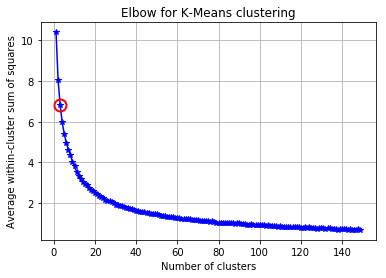

In [91]:
###  Cluster according to purely longitude and latitude
import numpy as np
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

##### cluster data into K=1..10 clusters #####
#K, KM, centroids,D_k,cIdx,dist,avgWithinSS = kmeans.run_kmeans(X,10)
X = loc.loc[loc['city'].isin(['tucson'])]
X = X[['center_y','center_x']]
K = range(1,150)

  # scipy.cluster.vq.kmeans
KM = [kmeans(X,k) for k in K] # apply kmeans 1 to ...
centroids = [cent for (cent,var) in KM]   # cluster centroids

D_k = [cdist(X, cent, 'euclidean') for cent in centroids]

cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist] 

kIdx = 2
# plot elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
      markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('Elbow for K-Means clustering')  

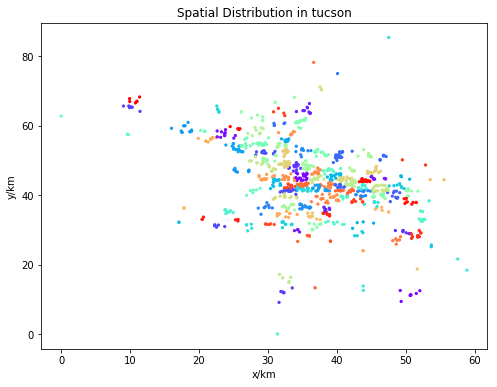

In [114]:
from sklearn.cluster import KMeans

km = KMeans(120, init='k-means++') # initialize
X = data[['center_x','center_y']]
km.fit(X)
label = km.predict(X) # classify into 120 clusters

import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(X['center_x'],X['center_y'], c = label,cmap='rainbow', s = 5)

plt.xlabel("x/km")
plt.ylabel("y/km")
plt.title("Spatial Distribution in " + str(list(city_list.keys())[1]))
# plt.xlim([0,100])
# plt.ylim([0,300])
plt.show()

In [115]:
import collections, numpy
print(collections.Counter(km.predict(X)))
data['label'] = label

Counter({102: 29, 67: 28, 12: 27, 82: 26, 39: 26, 16: 25, 77: 22, 73: 22, 81: 21, 1: 20, 117: 19, 26: 19, 60: 18, 13: 18, 103: 18, 21: 18, 23: 18, 15: 17, 27: 17, 53: 17, 59: 17, 32: 17, 8: 16, 98: 16, 31: 15, 6: 14, 108: 14, 93: 14, 79: 14, 83: 13, 28: 13, 97: 13, 94: 13, 76: 12, 25: 12, 2: 12, 66: 12, 84: 12, 58: 12, 68: 12, 99: 12, 91: 12, 61: 12, 90: 11, 69: 11, 57: 11, 112: 11, 96: 11, 46: 11, 72: 11, 14: 10, 48: 10, 22: 10, 71: 9, 63: 9, 5: 9, 20: 9, 70: 9, 116: 9, 24: 9, 86: 9, 109: 9, 3: 9, 7: 8, 37: 8, 42: 8, 50: 8, 75: 8, 35: 8, 0: 8, 62: 8, 49: 8, 10: 7, 64: 7, 51: 7, 17: 7, 95: 7, 78: 7, 107: 7, 113: 7, 9: 6, 56: 6, 119: 6, 89: 6, 11: 6, 100: 6, 55: 6, 18: 5, 38: 5, 74: 5, 40: 5, 118: 4, 110: 4, 29: 4, 104: 4, 30: 4, 4: 4, 36: 4, 115: 3, 87: 3, 114: 3, 65: 3, 43: 2, 80: 2, 88: 2, 33: 2, 34: 2, 92: 2, 44: 2, 52: 2, 111: 2, 106: 2, 41: 1, 19: 1, 47: 1, 54: 1, 105: 1, 85: 1, 45: 1, 101: 1})


D:\Download\Anaconda\A3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


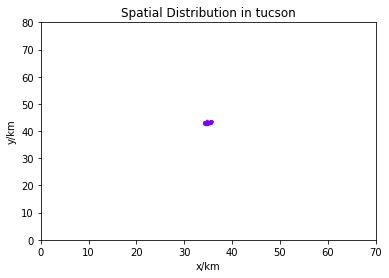

In [116]:
d = data.loc[data['label'] == 102]
plt.scatter(d['center_x'],d['center_y'], c = d['label'],cmap='rainbow', s = 5)

plt.xlabel("x/km")
plt.ylabel("y/km")
plt.title("Spatial Distribution in " + str(list(city_list.keys())[1]))
plt.xlim([0,70])
plt.ylim([0,80])
plt.show()

In [117]:
# To see if the distance is small enough
one = data.loc[data['label'] == 102]

one_1 = one.loc[one.index.repeat(len(one))].reset_index(drop=True) # reset index

one_2 = one
one_2 = pd.concat([one_2]*len(one_2), ignore_index=True)
one_2.rename(columns = {'loc_id':'loc_id_2','center_y': 'center_y_2','center_x':'center_x_2'},inplace=True)

one_3 = one_1.join(one_2, lsuffix='_one_1', rsuffix='_one_2') # IMPORTANT!!!

from sklearn.metrics.pairwise import pairwise_distances 
from sklearn.cluster import DBSCAN 
from geopy.distance import vincenty

# unit in km
one_3['distance'] = np.sqrt(np.square(one_3['center_y']-one_3['center_y_2'])+np.square(one_3['center_x']-one_3['center_x_2']))
one_distance_matrix = one_3.pivot_table(index=['loc_id'],columns=['loc_id_2'],values='distance')
one_distance_matrix.head()

loc_id_2,21,550,552,903,2224,3775,4141,4398,5238,5574,...,15933,17116,17223,17339,17512,17728,18060,18328,18520,18687
loc_id,,,,,,,,,,,,,,,,,,,,,
21,0.000000,0.935977,0.262850,0.909022,1.090466,0.508384,0.107829,0.298168,0.811937,0.853488,...,0.926631,0.044676,1.364122,0.925537,1.112587,0.541207,0.575307,0.580293,0.901669,0.680151
550,0.935977,0.000000,0.766365,0.084865,0.722124,0.967511,0.843076,0.677868,0.399511,0.386474,...,0.078539,0.966420,0.467489,0.520257,0.259369,1.150440,0.401862,1.280035,0.053715,0.439468
552,0.262850,0.766365,0.000000,0.760131,1.095626,0.682958,0.160783,0.316868,0.568166,0.610893,...,0.776335,0.265554,1.223560,0.669270,0.902529,0.765874,0.486120,0.827896,0.743216,0.436606
903,0.909022,0.084865,0.760131,0.000000,0.639403,0.902224,0.821597,0.637303,0.457472,0.450284,...,0.017902,0.942169,0.463532,0.589184,0.341640,1.088119,0.351965,1.220790,0.038968,0.477141
2224,1.090466,0.722124,1.095626,0.639403,0.000000,0.750489,1.057820,0.807593,1.062505,1.066952,...,0.643586,1.134806,0.713360,1.210917,0.958127,0.924629,0.634105,1.067281,0.677224,1.032510


In [118]:
one_distance_matrix.describe()

loc_id_2,21,550,552,903,2224,3775,4141,4398,5238,5574,...,15933,17116,17223,17339,17512,17728,18060,18328,18520,18687
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,...,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,0.715031,0.556473,0.647787,0.556909,0.884151,0.767934,0.663907,0.583763,0.585915,0.595494,...,0.563216,0.739683,0.886310,0.688057,0.669199,0.890996,0.534128,0.993807,0.547186,0.564350
std,0.371524,0.363391,0.290809,0.335334,0.253612,0.414637,0.335335,0.276586,0.362507,0.375299,...,0.342540,0.374790,0.396020,0.391835,0.430814,0.469362,0.195465,0.488574,0.342812,0.313645
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.508384,0.259369,0.436606,0.341640,0.735943,0.508384,0.546551,0.405391,0.384436,0.348169,...,0.330717,0.547556,0.525900,0.366475,0.322150,0.541207,0.401862,0.600517,0.312996,0.436606
50%,0.794816,0.498904,0.682958,0.568417,0.912637,0.916607,0.693315,0.636569,0.514332,0.536948,...,0.554102,0.819073,0.835880,0.591552,0.500150,1.083575,0.528859,1.180954,0.547149,0.489837
75%,0.935977,0.843076,0.785074,0.821597,1.067281,1.051279,0.843076,0.712038,0.825958,0.853488,...,0.838929,0.966420,1.268662,0.925537,1.010655,1.201162,0.635941,1.313644,0.811542,0.717211
max,1.364122,1.280035,1.223560,1.220790,1.271034,1.459909,1.281267,1.141705,1.303391,1.339781,...,1.237974,1.399358,1.602591,1.441826,1.513941,1.640008,0.886271,1.765759,1.231308,1.180954


In [ ]:
import geopy.distance

coords_1 = (max(max(numTrips['orig_lat']),max(numTrips['dest_lat'])), max(max(numTrips['orig_lon']),max(numTrips['dest_lon'])))
coords_2 = (min(min(numTrips['orig_lat']),min(numTrips['dest_lat'])), max(max(numTrips['orig_lon']),max(numTrips['dest_lon'])))
d1 = geopy.distance.vincenty(coords_1, coords_2).miles

coords_3 = (max(max(numTrips['orig_lat']),max(numTrips['dest_lat'])), max(max(numTrips['orig_lon']),max(numTrips['dest_lon'])))
coords_4 = (max(max(numTrips['orig_lat']),max(numTrips['dest_lat'])), min(min(numTrips['orig_lon']),min(numTrips['dest_lon'])))
d2 = geopy.distance.vincenty(coords_3, coords_4).miles

print(str(d1)+" miles")
print(str(d2)+" miles")